In [1]:
 #import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from sklearn.datasets import make_s_curve
data, color = make_s_curve(n_samples=1000)

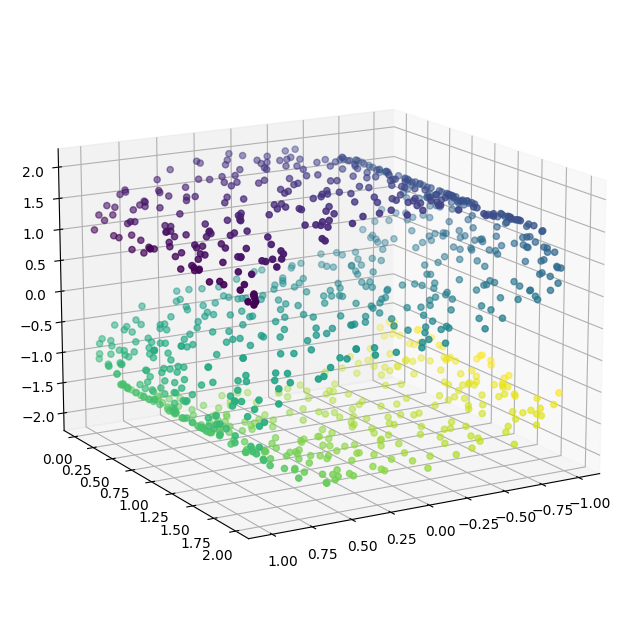

In [2]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data[:,0],ys=data[:,1],zs=data[:,2],c=color)
ax.view_init(15,60)

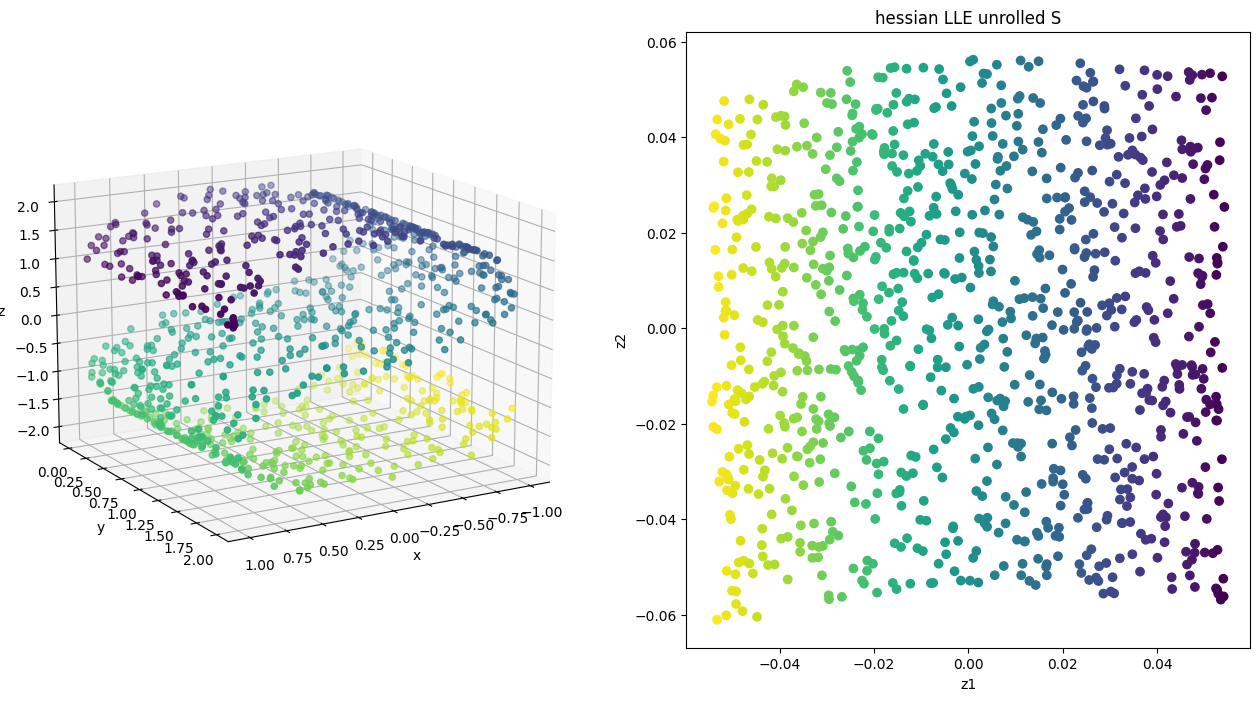

In [3]:
from sklearn.manifold import LocallyLinearEmbedding
n_neighbors = 25 # play with this and the method and see how visualization changes
n_components = 2
method = 'hessian' #alternative: 'standard' method (=standard LLE)
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors,
                             n_components=n_components, #=number of dimensions
                             reg=0.001,# regularization addition to combat getting singular matrices
                             eigen_solver='auto', #used for eigenvalue and eigenvector decomposition
                             tol=1e-6, # for arpack eigensolver
                             max_iter=100, # for arpack eigensolver
                             method=method, # 'modified', 'hessian', 'ltsa' (ltsa is not LLE but similar to it)
                                            # method also depends on how many neighors vs components we have
                             hessian_tol=0.0001, # tolerance for hessian method
                             modified_tol=1e-12, # tolerance for modified method
                             neighbors_algorithm='auto',
                             random_state=0,
                             n_jobs=2
                            )
data_transf = lle.fit_transform(data)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xs=data[:,0],ys=data[:,1],zs=data[:,2],c=color)
ax.view_init(15,60)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
ax = fig.add_subplot(122)
ax.scatter(x=data_transf[:,0],y=data_transf[:,1],c=color)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'{method} LLE unrolled S')
plt.show()

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit

data = fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]

    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Random Forest Classifier original dataset score: 0.891
Fit and score time: 3.31s

Random Forest Classifier 2 components score: 0.276
Fit and score time using 2 component standard LLE result: 0.67s

Random Forest Classifier original dataset score: 0.891
Fit and score time: 1.88s

Random Forest Classifier 2 components score: 0.569
Fit and score time using 2 component modified LLE result: 0.49s

Random Forest Classifier original dataset score: 0.891
Fit and score time: 3.53s

Random Forest Classifier 2 components score: 0.248
Fit and score time using 2 component hessian LLE result: 0.55s



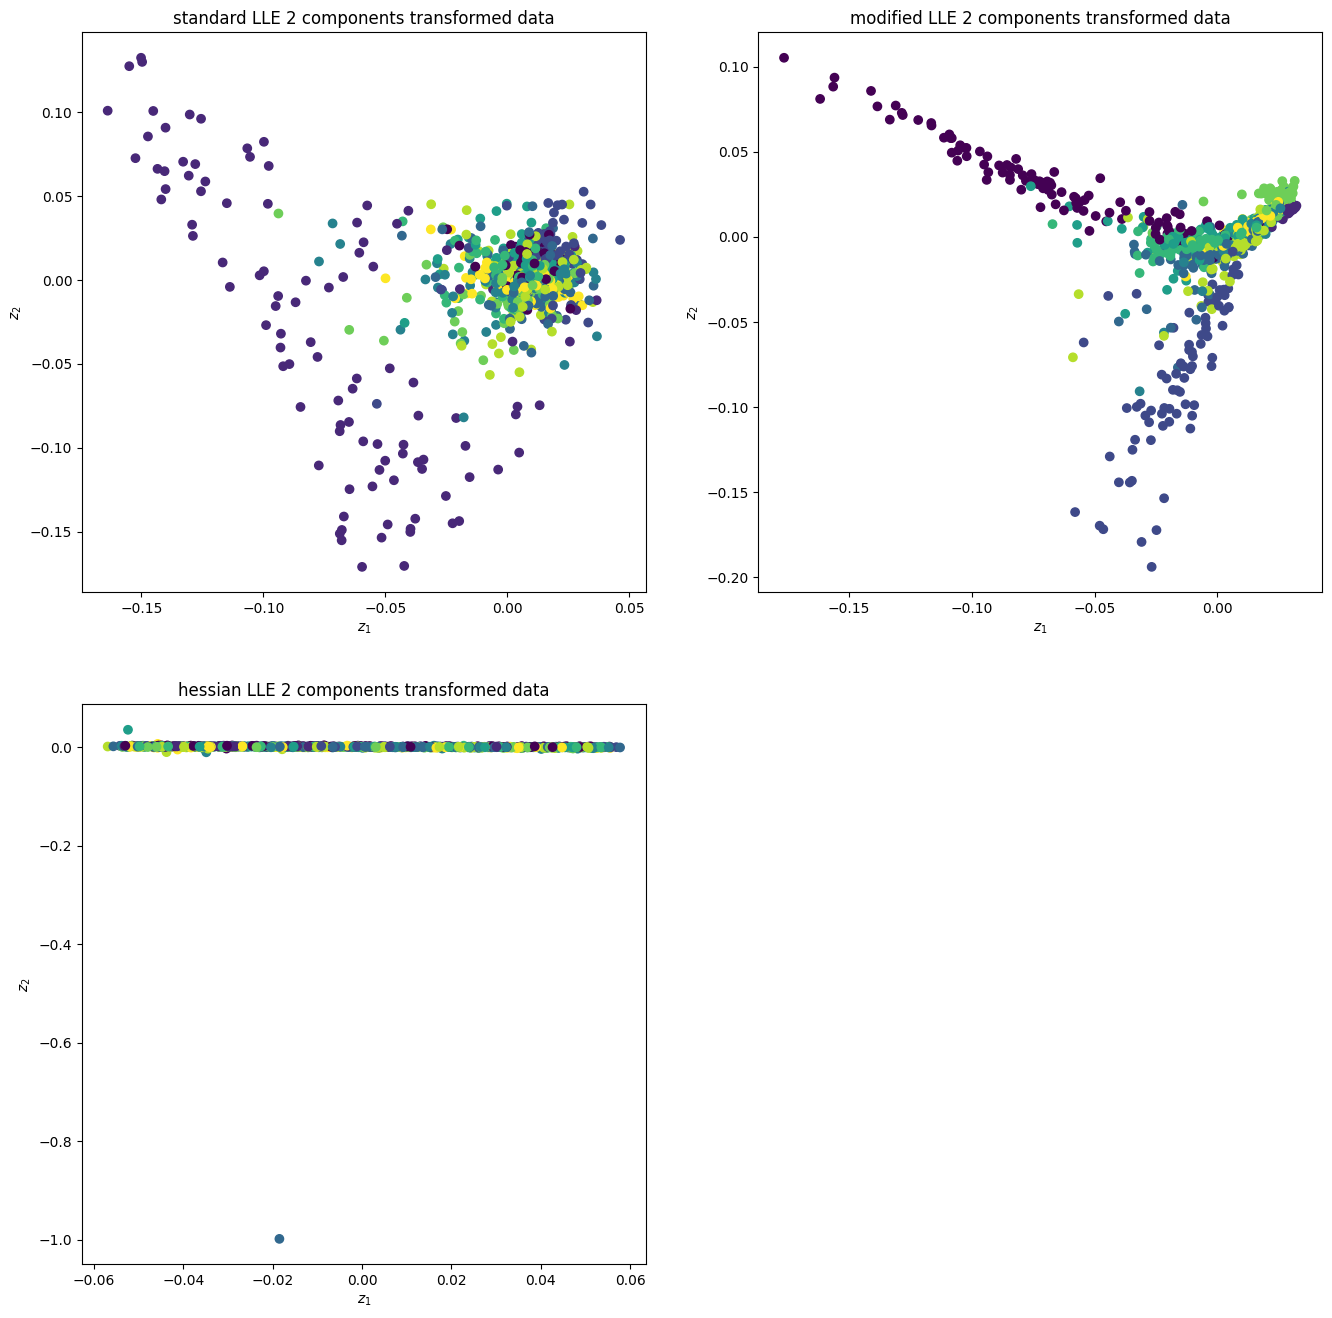

In [5]:
from sklearn.ensemble import RandomForestClassifier
import time
rfc_clf = RandomForestClassifier()

n_neighbors = 35
n_components = 2 #2 dimensions
numToPlot = 1000 #small part of the sample set to plot to avoid a super long training time and duplicate data points
methods = ['standard','modified','hessian']

fig = plt.figure(figsize=(16,16))
#looping over differnt methods and creating a plot for each point
for method in methods:
    ax = fig.add_subplot(2,2,methods.index(method)+1)
    lle = LocallyLinearEmbedding(n_neighbors=n_neighbors,
                                 n_components=n_components,
                                 method=method
                                )

    X_train_transf = lle.fit_transform(X_train.iloc[:numToPlot])
    X_test_transf = lle.transform(X_test)

    #plot our transformed points
    plt.scatter(X_train_transf[:, 0], X_train_transf[:, 1], c=y_train.astype(int).iloc[:numToPlot])
    plt.title(f'{method} LLE 2 components transformed data')
    plt.xlabel(r'$z_1$')
    plt.ylabel(r'$z_2$')


    #score our algorithms
    start = time.time()
    print('Random Forest Classifier original dataset score:',round(rfc_clf.fit(X_train.iloc[:numToPlot],
                                                                               y_train.iloc[:numToPlot]). \
                                                               score(X_test, y_test),3))
    print('Fit and score time:',str(round(time.time()-start,2))+'s\n')
    start = time.time()
    print('Random Forest Classifier 2 components score:',round(rfc_clf.fit(X_train_transf,y_train.iloc[:numToPlot]). \
                                                               score(X_test_transf, y_test),3))
    print(f'Fit and score time using 2 component {method} LLE result:',str(round(time.time()-start,2))+'s\n')
plt.show()

In [6]:
#now for 100 dimensions our accuracy decreases a little bit
n_components = 100
lle_100 = LocallyLinearEmbedding(n_neighbors=n_neighbors,
                                 n_components=n_components
                                )
X_train_transf = lle_100.fit_transform(X_train.iloc[:numToPlot])
X_test_transf = lle_100.transform(X_test)
start = time.time()

print('Random Forest Classifier 100 components score:',round(rfc_clf.fit(X_train_transf,y_train.iloc[:numToPlot]). \
                                                           score(X_test_transf, y_test),3))
print('Fit and score time using 100 component standard LLE result:',str(round(time.time()-start,2))+'s\n')

Random Forest Classifier 100 components score: 0.86
Fit and score time using 100 component standard LLE result: 1.15s

